In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

cancer.ipynb  health.ipynb  slide_1.png
/mnt/ufs18/home-144/dingjia5/projects/CosMx_liver/benchmark_generation_scripts


In [4]:
"""
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

'\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n'

In [5]:
"""
CosMx lung, kidney: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 

New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV

"""

'\nCosMx lung, kidney: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 196.992 um * 164.16 um = 32338.2067 um2\n3. In total: 20 spots / FOV\n\n'

In [6]:
"""
CosMx liver:
1. All FOVs are the same dimension: 4236 * 4236 pixels, 0.12um per pixel
2. simulated spot: 
        4236 / 3.0 = 1412 pixels = 169.44 um
        169.44 um * 169.44 um = 28709.9136 um2
"""

'\nCosMx liver:\n1. All FOVs are the same dimension: 4236 * 4236 pixels, 0.12um per pixel\n2. simulated spot: \n        4236 / 3.0 = 1412 pixels = 169.44 um\n        169.44 um * 169.44 um = 28709.9136 um2\n'

# Transcript Data

In [4]:

import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
from collections import Counter

In [5]:
CosMx_cell_type = pd.read_csv('../liver_cellType.csv')
CosMx_cell_type

Unnamed: 0       cell_ID                      cellType
0         c_1_100_10    c_1_100_10                         Hep.3
1       c_1_100_1078  c_1_100_1078                         Hep.4
2       c_1_100_1135  c_1_100_1135      Inflammatory.macrophages
3        c_1_100_267   c_1_100_267                         Hep.5
4        c_1_100_732   c_1_100_732          Central.venous.LSECs
...              ...           ...                           ...
793313     c_2_9_945     c_2_9_945      Inflammatory.macrophages
793314     c_2_9_947     c_2_9_947  Non.inflammatory.macrophages
793315     c_2_9_948     c_2_9_948                       tumor_1
793316     c_2_9_949     c_2_9_949                       tumor_1
793317      c_2_9_95      c_2_9_95                       tumor_1

[793318 rows x 3 columns]

In [6]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 11):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}


In [7]:
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == 5:
        sample_1_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    
    if fov_id not in sample_fov_count_dic[sample_id]:
        sample_fov_count_dic[sample_id].append(fov_id)
    
    if sample_id == 5:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1

len of cell_id_lst: 793318


In [8]:
print(sample_cell_count_dic)
print(sample_fov_count_dic)
print(fov_lst)
print(len(sample_1_index_lst))

{1: 332877, 2: 460441, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
{1: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 10, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 11, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 12, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 13, 140, 141, 142, 143, 144, 145, 146, 147, 149, 14, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 15, 160, 161, 162, 163, 164, 165, 166, 167, 169, 16, 170, 171, 172, 173, 174, 176, 177, 178, 179, 17, 182, 184, 185, 186, 187, 188, 189, 18, 190, 191, 192, 193, 194, 195, 197, 198, 199, 19, 1, 200, 201, 202, 203, 204, 205, 207, 208, 209, 20, 210, 211, 212, 214, 215, 216, 217, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 22, 230, 231, 234, 235, 236, 237, 238, 239, 23, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 24, 250, 251, 253, 254, 255, 256, 257, 258, 259, 25, 260, 261, 262, 263, 264, 265, 266, 269, 26, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 27, 280, 281, 282, 284, 286, 288, 28

In [9]:
len(sample_fov_count_dic[1]), len(sample_fov_count_dic[2])

(301, 383)

In [10]:
sample_1_rows = CosMx_cell_type["Unnamed: 0"].str.startswith("c_2_")
sample_1 = CosMx_cell_type.loc[sample_1_rows, :]
sample_1

Unnamed: 0      cell_ID                      cellType
993     c_2_100_733  c_2_100_733                       tumor_2
994     c_2_101_240  c_2_101_240                       tumor_1
995     c_2_101_339  c_2_101_339                       tumor_1
996     c_2_101_452  c_2_101_452                       tumor_1
997     c_2_102_179  c_2_102_179                       tumor_1
...             ...          ...                           ...
793313    c_2_9_945    c_2_9_945      Inflammatory.macrophages
793314    c_2_9_947    c_2_9_947  Non.inflammatory.macrophages
793315    c_2_9_948    c_2_9_948                       tumor_1
793316    c_2_9_949    c_2_9_949                       tumor_1
793317     c_2_9_95     c_2_9_95                       tumor_1

[460441 rows x 3 columns]

In [11]:
set(sample_1["cellType"].values.tolist())
sample_1_dic = {}
for index, row in sample_1.iterrows():
    if row["cellType"] in sample_1_dic:
        sample_1_dic[row["cellType"]] += 1
    else:
        sample_1_dic[row["cellType"]] = 1
        
sample_1_dic

{'tumor_2': 35385,
 'tumor_1': 347988,
 'Stellate.cells': 7798,
 'Inflammatory.macrophages': 14797,
 'CD3+.alpha.beta.T.cells': 20083,
 'Periportal.LSECs': 11893,
 'Non.inflammatory.macrophages': 9076,
 'Central.venous.LSECs': 2138,
 'Antibody.secreting.B.cells': 1236,
 'gamma.delta.T.cells.1': 549,
 'Mature.B.cells': 4974,
 'Erthyroid.cells': 139,
 'Hep': 1204,
 'NK.like.cells': 705,
 'Cholangiocytes': 1411,
 'Portal.endothelial.cells': 1060,
 'NotDet': 5}

In [12]:
cell_boundary = pd.read_csv('../liver_cell_positions_file.csv')
cell_boundary

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
793313     c_2_9_945     c_2_9_945      2710      4230     5.44420   
793314     c_2_9_947     c_2_9_947      2786      4233     5.45332   
793315     c_2_9_948     c_2_9_948      1732      4234     5.32684   
793316     c_2_9_949     c_2_9_949      1446      4239     5.29252   
793317      c_2_9_95      c_2_9_95      4211       649     5.62432   

        y_slide_mm  fov  
0          9.73500  100  
1          9.25824  100  
2          9.23412  100  
3          9.61104  100  
4          9.40548  100  
...            ...  ...  
793313    11.27840    9  
793314    11.27804    9  
793315    11.27792    9  
793316    11.27732    9  
793317    11.70812    9  

[793318 rows x 7 columns]

In [13]:
cell_boundary['cell_single_id'] = cell_boundary['cell_ID'].apply(lambda x: x.split('_')[-1])

In [14]:
cell_boundary

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
793313     c_2_9_945     c_2_9_945      2710      4230     5.44420   
793314     c_2_9_947     c_2_9_947      2786      4233     5.45332   
793315     c_2_9_948     c_2_9_948      1732      4234     5.32684   
793316     c_2_9_949     c_2_9_949      1446      4239     5.29252   
793317      c_2_9_95      c_2_9_95      4211       649     5.62432   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
793313    11.27840    9            945  
793314    11.27804    9            947  
793315    11.27792    9            948  
793316    11.27732    9            949  
793317    11.70812    9             95  

[793318 rows x 8 columns]

In [15]:
sample_1_rows = cell_boundary["cell_ID"].str.startswith("c_2_")
cell_boundary_health = cell_boundary.loc[sample_1_rows, :]
cell_boundary_health

Unnamed: 0      cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  y_slide_mm  \
993     c_2_100_733  c_2_100_733       443      1605     6.70816     9.03340   
994     c_2_101_240  c_2_101_240      2777      3037     7.50024     8.86156   
995     c_2_101_339  c_2_101_339      3655      4083     7.60560     8.73604   
996     c_2_101_452  c_2_101_452      3857       445     7.62984     9.17260   
997     c_2_102_179  c_2_102_179      1577      1936     7.86824     8.99368   
...             ...          ...       ...       ...         ...         ...   
793313    c_2_9_945    c_2_9_945      2710      4230     5.44420    11.27840   
793314    c_2_9_947    c_2_9_947      2786      4233     5.45332    11.27804   
793315    c_2_9_948    c_2_9_948      1732      4234     5.32684    11.27792   
793316    c_2_9_949    c_2_9_949      1446      4239     5.29252    11.27732   
793317     c_2_9_95     c_2_9_95      4211       649     5.62432    11.70812   

        fov cell_single_id  
993     100            733  
994     101            240  
995     101            339  
996     101            452  
997     102            179  
...     ...            ...  
793313    9            945  
793314    9            947  
793315    9            948  
793316    9            949  
793317    9             95  

[460441 rows x 8 columns]

In [16]:
fov_ids_lst_health = cell_boundary_health['fov'].unique()
fov_ids_lst_health

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109,  10, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119,  11, 120, 121, 122, 123,
       125, 126, 127, 128, 129,  12, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139,  13, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149,  14, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,  15,
       160, 161, 162, 164, 165, 166, 167, 168, 169,  16, 170, 172, 173,
       175, 176, 177, 178,  17, 180, 181, 182, 183, 184, 185, 187, 189,
        18, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,  19, 200,
       202, 203, 204, 205, 206, 207, 208, 209,  20, 210, 211, 212, 213,
       214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229,  22, 230, 231, 232, 234, 235, 236, 237, 238, 239,  23,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249,  24, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259,  25, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269,  26, 270, 271, 272, 273, 27

In [17]:
for fov_id in fov_ids_lst_health:
    print("fov_id:", fov_id, cell_boundary_health[(cell_boundary_health['fov']==fov_id)].shape)
    fov_whole = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]
#     print(fov_whole)
#     print(fov_whole["x_FOV_px"].max() - fov_whole["x_FOV_px"].min(), fov_whole["y_FOV_px"].max() - fov_whole["y_FOV_px"].min())
    print(fov_whole["x_FOV_px"].max(), fov_whole["x_FOV_px"].min())
    print(fov_whole["y_FOV_px"].max(), fov_whole["y_FOV_px"].min())
    

fov_id: 100 (1151, 8)
4240 14
4245 19
fov_id: 101 (1040, 8)
4237 21
4238 9
fov_id: 102 (1277, 8)
4237 14
4240 25
fov_id: 103 (1444, 8)
4231 17
4240 17
fov_id: 104 (1179, 8)
4228 16
4243 11
fov_id: 105 (1179, 8)
4238 26
4237 10
fov_id: 106 (859, 8)
4234 18
4241 31
fov_id: 107 (1473, 8)
4243 19
4244 13
fov_id: 108 (1462, 8)
4241 11
4235 18
fov_id: 109 (1278, 8)
4239 17
4240 19
fov_id: 10 (969, 8)
4229 12
4240 12
fov_id: 110 (1379, 8)
4236 13
4240 16
fov_id: 111 (1278, 8)
4241 19
4233 17
fov_id: 112 (1403, 8)
4241 13
4239 11
fov_id: 113 (1236, 8)
4242 13
4245 10
fov_id: 114 (1183, 8)
4240 18
4236 9
fov_id: 115 (1155, 8)
4238 21
4239 15
fov_id: 116 (1108, 8)
4243 18
4240 11
fov_id: 117 (1202, 8)
4238 15
4244 16
fov_id: 118 (1034, 8)
4240 18
4240 12
fov_id: 119 (1152, 8)
4232 14
4244 18
fov_id: 11 (877, 8)
4246 15
4233 20
fov_id: 120 (1099, 8)
4240 20
4242 20
fov_id: 121 (1151, 8)
4239 12
4238 14
fov_id: 122 (1195, 8)
4241 18
4234 17
fov_id: 123 (1195, 8)
4237 23
4241 8
fov_id: 125 (1383, 8

fov_id: 60 (1101, 8)
4243 16
4239 12
fov_id: 61 (1093, 8)
4237 14
4238 17
fov_id: 62 (1103, 8)
4237 16
4228 11
fov_id: 64 (1104, 8)
4241 13
4237 19
fov_id: 65 (1123, 8)
4241 16
4240 9
fov_id: 66 (1145, 8)
4220 17
4240 22
fov_id: 67 (1453, 8)
4244 15
4241 11
fov_id: 68 (1549, 8)
4240 14
4243 19
fov_id: 69 (1294, 8)
4247 15
4240 12
fov_id: 6 (1047, 8)
4243 18
4236 17
fov_id: 70 (1456, 8)
4236 18
4240 18
fov_id: 71 (1150, 8)
4229 21
4239 19
fov_id: 72 (1330, 8)
4239 19
4242 10
fov_id: 73 (1604, 8)
4232 15
4237 13
fov_id: 74 (1334, 8)
4244 14
4238 18
fov_id: 75 (1093, 8)
4244 16
4237 20
fov_id: 76 (1137, 8)
4239 8
4240 15
fov_id: 77 (1091, 8)
4242 13
4243 16
fov_id: 78 (1033, 8)
4241 18
4238 15
fov_id: 79 (1085, 8)
4234 17
4241 13
fov_id: 7 (1189, 8)
4242 14
4240 10
fov_id: 80 (1143, 8)
4245 21
4236 17
fov_id: 81 (759, 8)
4220 17
4223 17
fov_id: 82 (1180, 8)
4236 23
4239 16
fov_id: 83 (1341, 8)
4239 10
4243 15
fov_id: 84 (1234, 8)
4243 19
4237 19
fov_id: 85 (1273, 8)
4240 11
4240 15
fov_id

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

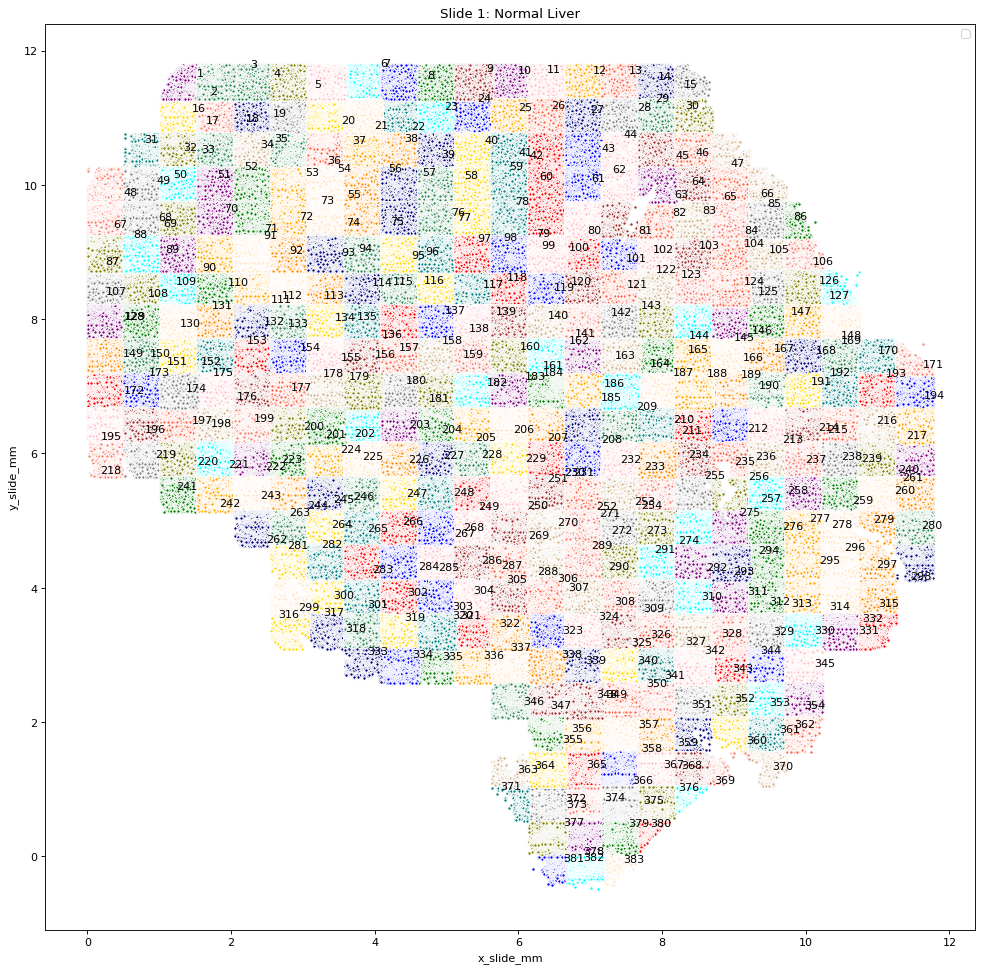

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", "gold", "teal"] * 25
recorded_fov = []
for i in range(len(fov_ids_lst_health)):
    fov_id = fov_ids_lst_health[i]
    X = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["x_slide_mm"].tolist()
    Y = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["y_slide_mm"].tolist()
    
#     plt.scatter(X, Y, s=100, label = fov_id,  c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.scatter(X, Y, s=40, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()
    
    if fov_id not in recorded_fov:
        plt.annotate(str(fov_id), (X[0], Y[0]))

plt.title('Slide 1: Normal Liver')
plt.xlabel('x_slide_mm')  
plt.ylabel('y_slide_mm')  
plt.savefig('slide_1.png') 
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

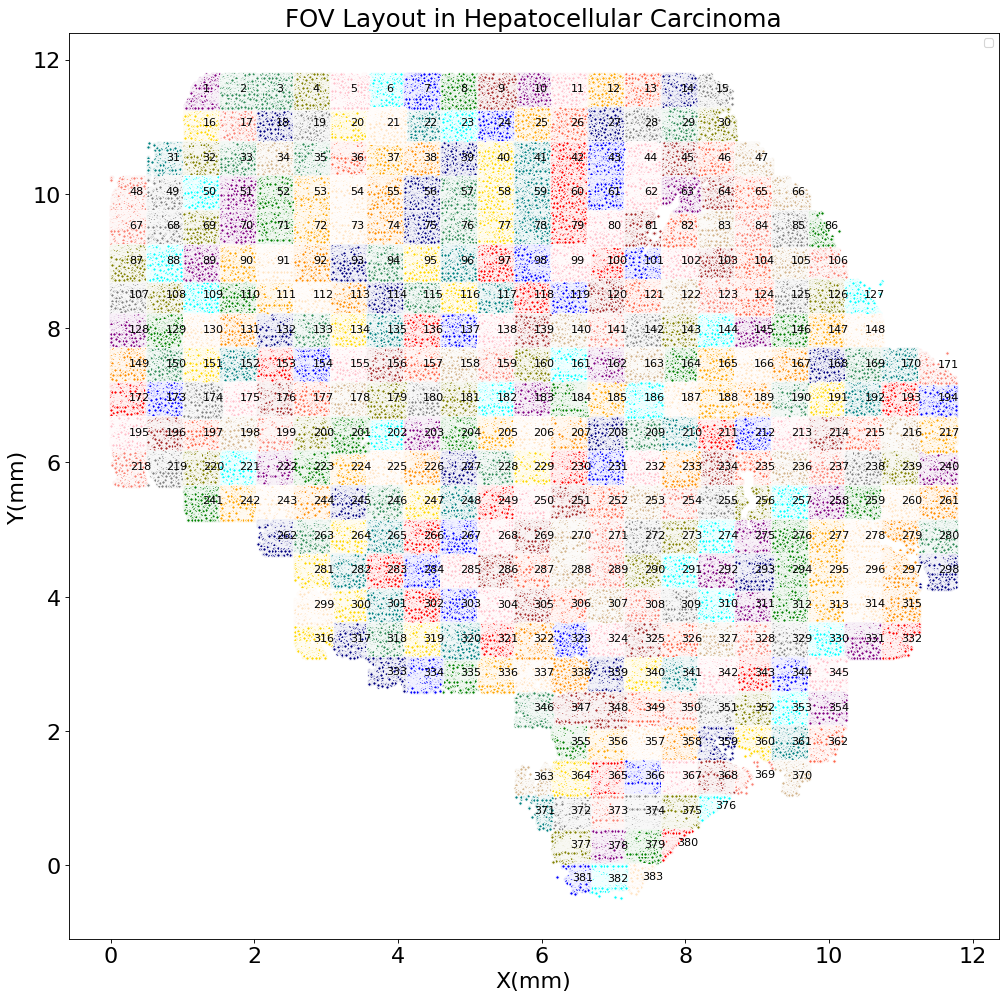

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", "gold", "teal"] * 25
recorded_fov = []
for i in range(len(fov_ids_lst_health)):
    fov_id = fov_ids_lst_health[i]
    X = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["x_slide_mm"].tolist()
    Y = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["y_slide_mm"].tolist()
#     import ipdb
#     ipdb.set_trace()

#     plt.scatter(X, Y, s=100, label = fov_id,  c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.scatter(X, Y, s=40, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()
    
    if fov_id not in recorded_fov:
#         plt.annotate(str(fov_id), (X[50], Y[50]), size=20)
        plt.annotate(str(fov_id), ((max(X) - min(X))/2.0 + min(X), (max(Y) - min(Y))/2.0 + min(Y)), size=10)
#     if i > 10:
#         break

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('FOV Layout in Hepatocellular Carcinoma',fontsize=22)
plt.xlabel('X(mm)', fontsize=20)  
plt.ylabel('Y(mm)', fontsize=20)  
plt.savefig("../../FOV_layout/cancer_liver.png", format="png", bbox_inches="tight")
plt.show()


# Benchmark Generation

## 1. spot_fov_cellId_mapping.csv

In [18]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    x_min = cell_boundary_fov_11["x_FOV_px"].min()
    x_max = cell_boundary_fov_11["x_FOV_px"].max()
    y_min = cell_boundary_fov_11["y_FOV_px"].min()
    y_max = cell_boundary_fov_11["y_FOV_px"].max()
    
#     print("x:", x_min, x_max)
#     print("y:", y_min, y_max)
    # x: 12 4245
    # y: 24 4236
#     import ipdb
#     ipdb.set_trace()
    x_diff = (x_max - x_min) / 3.0
    y_diff = (y_max - y_min) / 3.0
    
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["x_FOV_px"] <= x_min + x_diff * 1:
            if one_row_sample["y_FOV_px"] <= y_min + y_diff * 1:
                spot_id = 1
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 2:
                spot_id = 2
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 3:
                spot_id = 3
    

        elif one_row_sample["x_FOV_px"] <=  x_min + x_diff * 2:
            if one_row_sample["y_FOV_px"] <= y_min + y_diff * 1:
                spot_id = 4
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 2:
                spot_id = 5
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 3:
                spot_id = 6
     

        elif one_row_sample["x_FOV_px"] <= x_min + x_diff * 3:
            if one_row_sample["y_FOV_px"] <= y_min + y_diff * 1:
                spot_id = 7
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 2:
                spot_id = 8
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 3:
                spot_id = 9

        else:
            print("Wrong x_FOV_px, y_FOV_px:", one_row_sample["x_FOV_px"], one_row_sample["y_FOV_px"])
#         data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_single_id"]}, ignore_index = True)
        
        df1 = pd.DataFrame({'spot_id' : [spot_id], 'fov' : [one_row_sample["fov"]], 'cell_ID' : [one_row_sample["cell_single_id"]]})
        data_result = pd.concat([data_result, df1])
        
    return data_result

        

In [19]:
data_final_result = pd.DataFrame(columns = [ 'fov', 'spot_id', 'cell_ID'])
data_final_result

Empty DataFrame
Columns: [fov, spot_id, cell_ID]
Index: []

In [20]:
cell_boundary_health

Unnamed: 0      cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  y_slide_mm  \
993     c_2_100_733  c_2_100_733       443      1605     6.70816     9.03340   
994     c_2_101_240  c_2_101_240      2777      3037     7.50024     8.86156   
995     c_2_101_339  c_2_101_339      3655      4083     7.60560     8.73604   
996     c_2_101_452  c_2_101_452      3857       445     7.62984     9.17260   
997     c_2_102_179  c_2_102_179      1577      1936     7.86824     8.99368   
...             ...          ...       ...       ...         ...         ...   
793313    c_2_9_945    c_2_9_945      2710      4230     5.44420    11.27840   
793314    c_2_9_947    c_2_9_947      2786      4233     5.45332    11.27804   
793315    c_2_9_948    c_2_9_948      1732      4234     5.32684    11.27792   
793316    c_2_9_949    c_2_9_949      1446      4239     5.29252    11.27732   
793317     c_2_9_95     c_2_9_95      4211       649     5.62432    11.70812   

        fov cell_single_id  
993     100            733  
994     101            240  
995     101            339  
996     101            452  
997     102            179  
...     ...            ...  
793313    9            945  
793314    9            947  
793315    9            948  
793316    9            949  
793317    9             95  

[460441 rows x 8 columns]

In [21]:
type(cell_boundary_health)

pandas.core.frame.DataFrame

In [22]:
fov_ids_lst = cell_boundary_health['fov'].unique()
fov_ids_lst

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109,  10, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119,  11, 120, 121, 122, 123,
       125, 126, 127, 128, 129,  12, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139,  13, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149,  14, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,  15,
       160, 161, 162, 164, 165, 166, 167, 168, 169,  16, 170, 172, 173,
       175, 176, 177, 178,  17, 180, 181, 182, 183, 184, 185, 187, 189,
        18, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,  19, 200,
       202, 203, 204, 205, 206, 207, 208, 209,  20, 210, 211, 212, 213,
       214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229,  22, 230, 231, 232, 234, 235, 236, 237, 238, 239,  23,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249,  24, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259,  25, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269,  26, 270, 271, 272, 273, 27

In [29]:
fov_ids_lst = cell_boundary_health['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_health_fov =  cell_boundary_health[(cell_boundary_health['fov']==fov_id)]
    print("cell_boundary_health_fov_without_spot_id:", cell_boundary_health_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_health_fov)
#     print(data_final_result)
#     break

data_final_result

fov_ids_lst: [100 101 102 103 104 105 106 107 108 109  10 110 111 112 113 114 115 116
 117 118 119  11 120 121 122 123 125 126 127 128 129  12 130 131 132 133
 134 135 136 137 138 139  13 140 141 142 143 144 145 146 147 148 149  14
 150 151 152 153 154 155 156 157 158 159  15 160 161 162 164 165 166 167
 168 169  16 170 172 173 175 176 177 178  17 180 181 182 183 184 185 187
 189  18 190 191 192 193 194 195 196 197 198 199  19 200 202 203 204 205
 206 207 208 209  20 210 211 212 213 214 215 216 218 219 220 221 222 223
 224 225 226 227 228 229  22 230 231 232 234 235 236 237 238 239  23 240
 241 242 243 244 245 246 247 248 249  24 250 251 252 253 254 255 256 257
 258 259  25 260 261 262 263 264 265 266 267 268 269  26 270 271 272 273
 274 275 276 277 278 279  27 280 281 282 283 284 285 286 287 288 289  28
 290 291 292 294 295 296 297 298  29 300 301 302 303 304 305 306 307 308
 309  30 310 311 312 313 314 315 317 318 319  31 321 323 324 325 326 327
 328 329  32 330 331 335 336 337 338 3

fov_id: 202
cell_boundary_health_fov_without_spot_id: (1456, 8)
fov_id: 203
cell_boundary_health_fov_without_spot_id: (1490, 8)
fov_id: 204
cell_boundary_health_fov_without_spot_id: (1327, 8)
fov_id: 205
cell_boundary_health_fov_without_spot_id: (1281, 8)
fov_id: 206
cell_boundary_health_fov_without_spot_id: (1319, 8)
fov_id: 207
cell_boundary_health_fov_without_spot_id: (1073, 8)
fov_id: 208
cell_boundary_health_fov_without_spot_id: (1058, 8)
fov_id: 209
cell_boundary_health_fov_without_spot_id: (1127, 8)
fov_id: 20
cell_boundary_health_fov_without_spot_id: (1130, 8)
fov_id: 210
cell_boundary_health_fov_without_spot_id: (1248, 8)
fov_id: 211
cell_boundary_health_fov_without_spot_id: (1177, 8)
fov_id: 212
cell_boundary_health_fov_without_spot_id: (1033, 8)
fov_id: 213
cell_boundary_health_fov_without_spot_id: (1188, 8)
fov_id: 214
cell_boundary_health_fov_without_spot_id: (1241, 8)
fov_id: 215
cell_boundary_health_fov_without_spot_id: (1079, 8)
fov_id: 216
cell_boundary_health_fov_with

fov_id: 327
cell_boundary_health_fov_without_spot_id: (1233, 8)
fov_id: 328
cell_boundary_health_fov_without_spot_id: (1456, 8)
fov_id: 329
cell_boundary_health_fov_without_spot_id: (1440, 8)
fov_id: 32
cell_boundary_health_fov_without_spot_id: (1621, 8)
fov_id: 330
cell_boundary_health_fov_without_spot_id: (1695, 8)
fov_id: 331
cell_boundary_health_fov_without_spot_id: (1731, 8)
fov_id: 335
cell_boundary_health_fov_without_spot_id: (1169, 8)
fov_id: 336
cell_boundary_health_fov_without_spot_id: (1106, 8)
fov_id: 337
cell_boundary_health_fov_without_spot_id: (805, 8)
fov_id: 338
cell_boundary_health_fov_without_spot_id: (425, 8)
fov_id: 339
cell_boundary_health_fov_without_spot_id: (1025, 8)
fov_id: 33
cell_boundary_health_fov_without_spot_id: (1370, 8)
fov_id: 340
cell_boundary_health_fov_without_spot_id: (1334, 8)
fov_id: 341
cell_boundary_health_fov_without_spot_id: (1459, 8)
fov_id: 343
cell_boundary_health_fov_without_spot_id: (1505, 8)
fov_id: 344
cell_boundary_health_fov_without

fov_id: 342
cell_boundary_health_fov_without_spot_id: (1582, 8)
fov_id: 348
cell_boundary_health_fov_without_spot_id: (1289, 8)
fov_id: 362
cell_boundary_health_fov_without_spot_id: (984, 8)
fov_id: 363
cell_boundary_health_fov_without_spot_id: (360, 8)
fov_id: 369
cell_boundary_health_fov_without_spot_id: (218, 8)
fov_id: 372
cell_boundary_health_fov_without_spot_id: (874, 8)
fov_id: 377
cell_boundary_health_fov_without_spot_id: (1309, 8)
fov_id: 382
cell_boundary_health_fov_without_spot_id: (1041, 8)
fov_id: 63
cell_boundary_health_fov_without_spot_id: (836, 8)
fov_id: 86
cell_boundary_health_fov_without_spot_id: (467, 8)
fov_id: 188
cell_boundary_health_fov_without_spot_id: (1249, 8)
fov_id: 299
cell_boundary_health_fov_without_spot_id: (793, 8)
fov_id: 322
cell_boundary_health_fov_without_spot_id: (966, 8)
fov_id: 333
cell_boundary_health_fov_without_spot_id: (533, 8)
fov_id: 346
cell_boundary_health_fov_without_spot_id: (675, 8)
fov_id: 364
cell_boundary_health_fov_without_spot_id

fov spot_id cell_ID
0   100       2     733
0   100       8     101
0   100       7      25
0   100       8     102
0   100       3    1135
..  ...     ...     ...
0     5       2      92
0     5       2      94
0     5       5      95
0     5       8      96
0     5       2      98

[460441 rows x 3 columns]

In [30]:
data_final_result

fov spot_id cell_ID
0   100       2     733
0   100       8     101
0   100       7      25
0   100       8     102
0   100       3    1135
..  ...     ...     ...
0     5       2      92
0     5       2      94
0     5       5      95
0     5       8      96
0     5       2      98

[460441 rows x 3 columns]

In [31]:
data_final_result_sample = data_final_result[(data_final_result['fov']==8)]
data_final_result_sample

fov spot_id cell_ID
0    8       2     201
0    8       8     291
0    8       2     351
0    8       4      41
0    8       9     438
..  ..     ...     ...
0    8       6     879
0    8       3     880
0    8       9     882
0    8       9     884
0    8       3     885

[880 rows x 3 columns]

In [32]:
data_final_result.to_csv('../cancer/new/spot_fov_cellId_mapping.csv')

In [34]:
data_final_result

fov spot_id cell_ID
0   100       2     733
0   100       8     101
0   100       7      25
0   100       8     102
0   100       3    1135
..  ...     ...     ...
0     5       2      92
0     5       2      94
0     5       5      95
0     5       8      96
0     5       2      98

[460441 rows x 3 columns]

## 2. spot_gene_expression.csv

In [35]:
cell_boundary

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
793313     c_2_9_945     c_2_9_945      2710      4230     5.44420   
793314     c_2_9_947     c_2_9_947      2786      4233     5.45332   
793315     c_2_9_948     c_2_9_948      1732      4234     5.32684   
793316     c_2_9_949     c_2_9_949      1446      4239     5.29252   
793317      c_2_9_95      c_2_9_95      4211       649     5.62432   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
793313    11.27840    9            945  
793314    11.27804    9            947  
793315    11.27792    9            948  
793316    11.27732    9            949  
793317    11.70812    9             95  

[793318 rows x 8 columns]

In [36]:
CosMx_cell_type

Unnamed: 0       cell_ID                      cellType
0         c_1_100_10    c_1_100_10                         Hep.3
1       c_1_100_1078  c_1_100_1078                         Hep.4
2       c_1_100_1135  c_1_100_1135      Inflammatory.macrophages
3        c_1_100_267   c_1_100_267                         Hep.5
4        c_1_100_732   c_1_100_732          Central.venous.LSECs
...              ...           ...                           ...
793313     c_2_9_945     c_2_9_945      Inflammatory.macrophages
793314     c_2_9_947     c_2_9_947  Non.inflammatory.macrophages
793315     c_2_9_948     c_2_9_948                       tumor_1
793316     c_2_9_949     c_2_9_949                       tumor_1
793317      c_2_9_95      c_2_9_95                       tumor_1

[793318 rows x 3 columns]

In [37]:
gene_expression_cell_type = pd.concat([cell_boundary.iloc[:,-2:], CosMx_cell_type.iloc[:,-2:]], axis=1)
gene_expression_cell_type

fov cell_single_id       cell_ID                      cellType
0       100             10    c_1_100_10                         Hep.3
1       100           1078  c_1_100_1078                         Hep.4
2       100           1135  c_1_100_1135      Inflammatory.macrophages
3       100            267   c_1_100_267                         Hep.5
4       100            732   c_1_100_732          Central.venous.LSECs
...     ...            ...           ...                           ...
793313    9            945     c_2_9_945      Inflammatory.macrophages
793314    9            947     c_2_9_947  Non.inflammatory.macrophages
793315    9            948     c_2_9_948                       tumor_1
793316    9            949     c_2_9_949                       tumor_1
793317    9             95      c_2_9_95                       tumor_1

[793318 rows x 4 columns]

In [38]:
import anndata as ad
liver_anndata = ad.read_h5ad("../cosmx_Liver.h5ad")
liver_anndata

AnnData object with n_obs × n_vars = 793318 × 1000
    obs: 'RNA_pca_cluster_default', 'RNA_pca_cluster_default.1', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18', 'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'Run_name', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Mean.Yellow', 'Max.Yellow', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'cell_ID', 'x_FOV_px', 'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'propNegative', 'complexity', 'errorCtEstimate', 'percOfDataFromError', 'qcFlagsRNACounts', 'qcFlagsCellCounts', 'qcFlagsCellPropNeg', 'qcFlagsCellComplex', 'qcFlagsCellArea', 'median_negprobes', 'negprobes_quantile_0.9', 'median_RNA', 'RNA_quantile_0.9', 'nCell', 'nCount', 'nCountPerCell', 'nFeaturePerCell', 'propNegativeCellAvg', 'complexityCellAvg', '

In [39]:
liver_raw = liver_anndata.raw.X.toarray()
liver_raw

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 2.]])

In [40]:
liver_raw.shape

(793318, 1000)

In [41]:
liver_anndata.var

I  pval  padj
AATK    0.009963   0.0   0.0
ABL1    0.014579   0.0   0.0
ABL2    0.006918   0.0   0.0
ACACB   0.026519   0.0   0.0
ACE     0.018274   0.0   0.0
...          ...   ...   ...
XKR4    0.008696   0.0   0.0
YBX3    0.172319   0.0   0.0
YES1    0.010316   0.0   0.0
ZBTB16  0.094404   0.0   0.0
ZFP36   0.158102   0.0   0.0

[1000 rows x 3 columns]

In [42]:
list(liver_anndata.var.index)


['AATK',
 'ABL1',
 'ABL2',
 'ACACB',
 'ACE',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACP5',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF5',
 'ADGRG1',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'AGR2',
 'AHI1',
 'AHR',
 'AIF1',
 'AKT1',
 'ALCAM',
 'ALOX5AP',
 'ANGPT1',
 'ANGPT2',
 'ANGPTL1',
 'ANKRD1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOC1',
 'APOD',
 'APOE',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARID5B',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATP5F1B',
 'ATP5F1E',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BASP1',
 'BAX',
 'BBLN',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC3',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BRAF',
 'BRCA1',
 'BST1',
 'BST2',
 'BTF3',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA',
 'C1QB',


In [43]:
individual_cell_gene_expression = pd.DataFrame(liver_raw, columns = list(liver_anndata.var.index))
individual_cell_gene_expression

AATK  ABL1  ABL2  ACACB  ACE  ACKR1  ACKR3  ACKR4  ACP5  ACTA2  ...  \
0        0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
1        1.0   2.0   0.0    2.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
2        0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
3        0.0   0.0   0.0    1.0  0.0    0.0    0.0    1.0   0.0    2.0  ...   
4        0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    1.0  ...   
...      ...   ...   ...    ...  ...    ...    ...    ...   ...    ...  ...   
793313   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
793314   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
793315   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   1.0    0.0  ...   
793316   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
793317   0.0   1.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   

        WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  YBX3  YES1  ZBTB16  ZFP36  
0         0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
1         0.0    0.0    0.0   1.0   0.0   0.0   1.0   0.0     4.0    0.0  
2         0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
3         0.0    0.0    0.0   2.0   0.0   0.0   1.0   0.0     0.0    0.0  
4         0.0    0.0    0.0   0.0   0.0   0.0   1.0   0.0     1.0    0.0  
...       ...    ...    ...   ...   ...   ...   ...   ...     ...    ...  
793313    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
793314    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
793315    0.0    1.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    1.0  
793316    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
793317    0.0    1.0    0.0   0.0   0.0   0.0   1.0   0.0     0.0    2.0  

[793318 rows x 1000 columns]

In [44]:
individual_cell_gene_expression = pd.concat([gene_expression_cell_type, individual_cell_gene_expression], axis=1)
individual_cell_gene_expression


fov cell_single_id       cell_ID                      cellType  AATK  \
0       100             10    c_1_100_10                         Hep.3   0.0   
1       100           1078  c_1_100_1078                         Hep.4   1.0   
2       100           1135  c_1_100_1135      Inflammatory.macrophages   0.0   
3       100            267   c_1_100_267                         Hep.5   0.0   
4       100            732   c_1_100_732          Central.venous.LSECs   0.0   
...     ...            ...           ...                           ...   ...   
793313    9            945     c_2_9_945      Inflammatory.macrophages   0.0   
793314    9            947     c_2_9_947  Non.inflammatory.macrophages   0.0   
793315    9            948     c_2_9_948                       tumor_1   0.0   
793316    9            949     c_2_9_949                       tumor_1   0.0   
793317    9             95      c_2_9_95                       tumor_1   0.0   

        ABL1  ABL2  ACACB  ACE  ACKR1  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  \
0        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
1        2.0   0.0    2.0  0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   
2        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
3        0.0   0.0    1.0  0.0    0.0  ...    0.0    0.0    0.0   2.0   0.0   
4        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
...      ...   ...    ...  ...    ...  ...    ...    ...    ...   ...   ...   
793313   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793314   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793315   0.0   0.0    0.0  0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   
793316   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793317   1.0   0.0    0.0  0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   

        XKR4  YBX3  YES1  ZBTB16  ZFP36  
0        0.0   0.0   0.0     0.0    0.0  
1        0.0   1.0   0.0     4.0    0.0  
2        0.0   0.0   0.0     0.0    0.0  
3        0.0   1.0   0.0     0.0    0.0  
4        0.0   1.0   0.0     1.0    0.0  
...      ...   ...   ...     ...    ...  
793313   0.0   0.0   0.0     0.0    0.0  
793314   0.0   0.0   0.0     0.0    0.0  
793315   0.0   0.0   0.0     0.0    1.0  
793316   0.0   0.0   0.0     0.0    0.0  
793317   0.0   1.0   0.0     0.0    2.0  

[793318 rows x 1004 columns]

In [45]:
sample_1_rows = individual_cell_gene_expression["cell_ID"].str.startswith("c_2_")
individual_cell_gene_expression = individual_cell_gene_expression.loc[sample_1_rows, :]
individual_cell_gene_expression

fov cell_single_id      cell_ID                      cellType  AATK  \
993     100            733  c_2_100_733                       tumor_2   0.0   
994     101            240  c_2_101_240                       tumor_1   0.0   
995     101            339  c_2_101_339                       tumor_1   0.0   
996     101            452  c_2_101_452                       tumor_1   1.0   
997     102            179  c_2_102_179                       tumor_1   2.0   
...     ...            ...          ...                           ...   ...   
793313    9            945    c_2_9_945      Inflammatory.macrophages   0.0   
793314    9            947    c_2_9_947  Non.inflammatory.macrophages   0.0   
793315    9            948    c_2_9_948                       tumor_1   0.0   
793316    9            949    c_2_9_949                       tumor_1   0.0   
793317    9             95     c_2_9_95                       tumor_1   0.0   

        ABL1  ABL2  ACACB  ACE  ACKR1  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  \
993      0.0   0.0    1.0  0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   
994      2.0   0.0    1.0  0.0    0.0  ...    0.0    0.0    1.0  12.0   1.0   
995      0.0   1.0    2.0  1.0    0.0  ...    0.0    0.0    0.0   5.0   0.0   
996      0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   
997      1.0   0.0    0.0  0.0    0.0  ...    1.0    0.0    0.0   4.0   3.0   
...      ...   ...    ...  ...    ...  ...    ...    ...    ...   ...   ...   
793313   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793314   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793315   0.0   0.0    0.0  0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   
793316   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793317   1.0   0.0    0.0  0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   

        XKR4  YBX3  YES1  ZBTB16  ZFP36  
993      0.0   0.0   0.0     0.0    1.0  
994      0.0   4.0   4.0     9.0    1.0  
995      0.0   3.0   1.0     2.0    9.0  
996      0.0   7.0   0.0     2.0    1.0  
997      0.0  11.0   0.0     8.0   21.0  
...      ...   ...   ...     ...    ...  
793313   0.0   0.0   0.0     0.0    0.0  
793314   0.0   0.0   0.0     0.0    0.0  
793315   0.0   0.0   0.0     0.0    1.0  
793316   0.0   0.0   0.0     0.0    0.0  
793317   0.0   1.0   0.0     0.0    2.0  

[460441 rows x 1004 columns]

In [46]:
del individual_cell_gene_expression['cell_ID']
individual_cell_gene_expression = individual_cell_gene_expression.rename(columns={'cell_single_id': 'cell_ID'})
individual_cell_gene_expression['cell_ID'] = individual_cell_gene_expression['cell_ID'].astype('int')
individual_cell_gene_expression

fov  cell_ID                      cellType  AATK  ABL1  ABL2  ACACB  \
993     100      733                       tumor_2   0.0   0.0   0.0    1.0   
994     101      240                       tumor_1   0.0   2.0   0.0    1.0   
995     101      339                       tumor_1   0.0   0.0   1.0    2.0   
996     101      452                       tumor_1   1.0   0.0   0.0    0.0   
997     102      179                       tumor_1   2.0   1.0   0.0    0.0   
...     ...      ...                           ...   ...   ...   ...    ...   
793313    9      945      Inflammatory.macrophages   0.0   0.0   0.0    0.0   
793314    9      947  Non.inflammatory.macrophages   0.0   0.0   0.0    0.0   
793315    9      948                       tumor_1   0.0   0.0   0.0    0.0   
793316    9      949                       tumor_1   0.0   0.0   0.0    0.0   
793317    9       95                       tumor_1   0.0   1.0   0.0    0.0   

        ACE  ACKR1  ACKR3  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  YBX3  \
993     0.0    0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   0.0   
994     0.0    0.0    2.0  ...    0.0    0.0    1.0  12.0   1.0   0.0   4.0   
995     1.0    0.0    1.0  ...    0.0    0.0    0.0   5.0   0.0   0.0   3.0   
996     0.0    0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   7.0   
997     0.0    0.0    1.0  ...    1.0    0.0    0.0   4.0   3.0   0.0  11.0   
...     ...    ...    ...  ...    ...    ...    ...   ...   ...   ...   ...   
793313  0.0    0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
793314  0.0    0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
793315  0.0    0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   0.0   0.0   
793316  0.0    0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
793317  0.0    0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   0.0   1.0   

        YES1  ZBTB16  ZFP36  
993      0.0     0.0    1.0  
994      4.0     9.0    1.0  
995      1.0     2.0    9.0  
996      0.0     2.0    1.0  
997      0.0     8.0   21.0  
...      ...     ...    ...  
793313   0.0     0.0    0.0  
793314   0.0     0.0    0.0  
793315   0.0     0.0    1.0  
793316   0.0     0.0    0.0  
793317   0.0     0.0    2.0  

[460441 rows x 1003 columns]

In [49]:
# type(individual_cell_gene_expression["cell_ID"][0])


In [48]:
data_final_result = pd.read_csv('../cancer/new/spot_fov_cellId_mapping.csv')
data_final_result

Unnamed: 0  fov  spot_id  cell_ID
0                0  100        2      733
1                0  100        8      101
2                0  100        7       25
3                0  100        8      102
4                0  100        3     1135
...            ...  ...      ...      ...
460436           0    5        2       92
460437           0    5        2       94
460438           0    5        5       95
460439           0    5        8       96
460440           0    5        2       98

[460441 rows x 4 columns]

In [50]:
individual_cell_gene_expression = pd.merge(data_final_result, individual_cell_gene_expression, on=['fov', 'cell_ID'])
individual_cell_gene_expression

Unnamed: 0  fov  spot_id  cell_ID                  cellType  AATK  \
0                0  100        2      733                   tumor_2   0.0   
1                0  100        8      101                   tumor_1   1.0   
2                0  100        7       25                   tumor_2   0.0   
3                0  100        8      102                   tumor_1   2.0   
4                0  100        3     1135                   tumor_2   0.0   
...            ...  ...      ...      ...                       ...   ...   
460436           0    5        2       92                   tumor_2   0.0   
460437           0    5        2       94                   tumor_1   1.0   
460438           0    5        5       95  Inflammatory.macrophages   0.0   
460439           0    5        8       96                   tumor_1   0.0   
460440           0    5        2       98                   tumor_1   3.0   

        ABL1  ABL2  ACACB  ACE  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  \
0        0.0   0.0    1.0  0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   
1        1.0   0.0    1.0  0.0  ...    0.0    0.0    0.0   4.0   0.0   0.0   
2        2.0   0.0    0.0  1.0  ...    1.0    0.0    0.0   0.0   2.0   0.0   
3        0.0   0.0    3.0  1.0  ...    0.0    2.0    0.0   3.0   0.0   0.0   
4        1.0   1.0    2.0  1.0  ...    0.0    0.0    0.0   0.0   1.0   0.0   
...      ...   ...    ...  ...  ...    ...    ...    ...   ...   ...   ...   
460436   1.0   0.0    0.0  0.0  ...    1.0    0.0    1.0   1.0   1.0   0.0   
460437   1.0   0.0    0.0  0.0  ...    0.0    1.0    0.0   0.0   0.0   0.0   
460438   1.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
460439   0.0   0.0    1.0  0.0  ...    0.0    2.0    0.0   0.0   0.0   0.0   
460440   1.0   0.0    0.0  1.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   

        YBX3  YES1  ZBTB16  ZFP36  
0        0.0   0.0     0.0    1.0  
1        9.0   3.0     2.0   12.0  
2        5.0   1.0     8.0    2.0  
3        5.0   1.0    15.0    5.0  
4        1.0   0.0     3.0    1.0  
...      ...   ...     ...    ...  
460436   1.0   0.0     2.0    5.0  
460437   0.0   0.0     2.0    0.0  
460438   0.0   0.0     1.0    2.0  
460439   0.0   0.0     1.0    0.0  
460440   1.0   0.0     1.0    0.0  

[460441 rows x 1005 columns]

In [51]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9'])
fov_spot_cells_stats


Empty DataFrame
Columns: [fov, spot-id=1, spot-id=2, spot-id=3, spot-id=4, spot-id=5, spot-id=6, spot-id=7, spot-id=8, spot-id=9]
Index: []

In [52]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0}

In [53]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9]

for fov_id in fov_ids_lst:
    fov_data = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)

fov_spot_cells_stats

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_31546/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

fov spot-id=1 spot-id=2 spot-id=3 spot-id=4 spot-id=5 spot-id=6  \
0    100       146       144       134       146       129       106   
1    101       133       115       129        51        72        80   
2    102       185       132       160       118        75       136   
3    103       255       147       122       146       146       152   
4    104       185       150       112       134       121       147   
..   ...       ...       ...       ...       ...       ...       ...   
378  364        42        75        61       157        81        86   
379  371        12         0         0        30        15        13   
380  380        90        86        32        94        27         0   
381  381         7         8         0        73       102        41   
382    5        90        85       133        65        58        61   

    spot-id=7 spot-id=8 spot-id=9  
0         115       122       109  
1         163       136       161  
2         227       115       129  
3         155       165       156  
4         115        99       116  
..        ...       ...       ...  
378       118        77        77  
379        86        73        43  
380        17         0         0  
381       152       143        77  
382        58        55        95  

[383 rows x 10 columns]

In [55]:
fov_spot_cells_stats.to_csv('../cancer/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

fov spot-id=1 spot-id=2 spot-id=3 spot-id=4 spot-id=5 spot-id=6  \
0    100       146       144       134       146       129       106   
1    101       133       115       129        51        72        80   
2    102       185       132       160       118        75       136   
3    103       255       147       122       146       146       152   
4    104       185       150       112       134       121       147   
..   ...       ...       ...       ...       ...       ...       ...   
378  364        42        75        61       157        81        86   
379  371        12         0         0        30        15        13   
380  380        90        86        32        94        27         0   
381  381         7         8         0        73       102        41   
382    5        90        85       133        65        58        61   

    spot-id=7 spot-id=8 spot-id=9  
0         115       122       109  
1         163       136       161  
2         227       115       129  
3         155       165       156  
4         115        99       116  
..        ...       ...       ...  
378       118        77        77  
379        86        73        43  
380        17         0         0  
381       152       143        77  
382        58        55        95  

[383 rows x 10 columns]

In [56]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = (individual_cell_gene_expression.columns)[5:].tolist()
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACACB',
 'ACE',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACP5',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF5',
 'ADGRG1',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'AGR2',
 'AHI1',
 'AHR',
 'AIF1',
 'AKT1',
 'ALCAM',
 'ALOX5AP',
 'ANGPT1',
 'ANGPT2',
 'ANGPTL1',
 'ANKRD1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOC1',
 'APOD',
 'APOE',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARID5B',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATP5F1B',
 'ATP5F1E',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BASP1',
 'BAX',
 'BBLN',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC3',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BRAF',
 'BRCA1',
 'BST1',
 'BST2',
 'BTF3',
 'BTG1',
 'BTK',
 'C11orf96'

In [57]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


Empty DataFrame
Columns: [fov, spot_id, AATK, ABL1, ABL2, ACACB, ACE, ACKR1, ACKR3, ACKR4, ACP5, ACTA2, ACTG2, ACVR1, ACVR1B, ACVR2A, ACVRL1, ADGRA2, ADGRA3, ADGRE2, ADGRE5, ADGRF1, ADGRF3, ADGRF5, ADGRG1, ADGRG3, ADGRG5, ADGRG6, ADGRL1, ADGRL2, ADGRL4, ADGRV1, ADIPOQ, ADIRF, ADM2, AGR2, AHI1, AHR, AIF1, AKT1, ALCAM, ALOX5AP, ANGPT1, ANGPT2, ANGPTL1, ANKRD1, ANXA1, ANXA2, ANXA4, APOA1, APOC1, APOD, APOE, APP, AQP3, AR, AREG, ARF1, ARG1, ARHGDIB, ARID5B, ATF3, ATG10, ATG12, ATG5, ATM, ATP5F1B, ATP5F1E, ATR, AXL, AZGP1, AZU1, B2M, B3GNT7, BAG3, BASP1, BAX, BBLN, BCL2, BCL2L1, BECN1, BEST1, BGN, BID, BIRC3, BIRC5, BMP1, BMP2, BMP3, BMP4, BMP5, BMP7, BMPR1A, BMPR2, BRAF, BRCA1, BST1, BST2, BTF3, BTG1, ...]
Index: []

[0 rows x 1002 columns]

In [58]:
def get_spot_gene_expression(fov_expression, spot_id):
    genes_lst = (fov_expression.columns)[5:].tolist()
    assert len(genes_lst) == 1000
    
    cell_id_lst = fov_expression[(fov_expression['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        
        cell_gene_expression = cell_gene_expression.values.tolist()[0][5:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()

    return cell_gene_expression_total
    
    


In [59]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9]

for fov_id in fov_ids_lst:
    fov_gene_expression = individual_cell_gene_expression[(individual_cell_gene_expression['fov'] == fov_id)]
    print("fov_id:", fov_id)
    
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_gene_expression, spot_id)
        
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
        
#     print(spot_gene_express, len(spot_gene_express))



  

fov_id: 100


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 101


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 102


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 103


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 104


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 105


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 106


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 107


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 108


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 109


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 10


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 110


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 111


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 112


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 113


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 114


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 115


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 116


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 117


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 118


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 119


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 11


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 120


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 121


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 122


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 123


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 125


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 126


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 127


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 128


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 129


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 12


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 130


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 131


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 132


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 133


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 134


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 135


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 136


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 137


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 138


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 139


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 13


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 140


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 141


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 142


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 143


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 144


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 145


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 146


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 147


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 148


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 149


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 14


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 150


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 151


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 152


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 153


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 154


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 155


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 156


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 157


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 158


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 159


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 15


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 160


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 161


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 162


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 164


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 165


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 166


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 167


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 168


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 169


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 16


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 170


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 172


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 173


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 175


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 176


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 177


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 178


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 17


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 180


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 181


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 182


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 183


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 184


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 185


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 187


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 189


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 18


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 190


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 191


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 192


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 193


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 194


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 195


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 196


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 197


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 198


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 199


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 19


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 200


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 202


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 203


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 204


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 205


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 206


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 207


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 208


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 209


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 20


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 210


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 211


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 212


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 213


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 214


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 215


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 216


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 218


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 219


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 220


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 221


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 222


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 223


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 224


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 225


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 226


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 227


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 228


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 229


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 22


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 230


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 231


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 232


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 234


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 235


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 236


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 237


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 238


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 239


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 23


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 240


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 241


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 242


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 243


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 244


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 245


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 246


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 247


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 248


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 249


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 24


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 250


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 251


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 252


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 253


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 254


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 255


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 256


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 257


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 258


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 259


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 25


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 260


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 261


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 262


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 263


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 264


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 265


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 266


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 267


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 268


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 269


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 26


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 270


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 271


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 272


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 273


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 274


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 275


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 276


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 277


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 278


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 279


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 27


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 280


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 281


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 282


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 283


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 284


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 285


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 286


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 287


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 288


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 289


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 28


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 290


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 291


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 292


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 294


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 295


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 296


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 297


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 298


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 29


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 300


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 301


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 302


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 303


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 304


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 305


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 306


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 307


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 308


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 309


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 30


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 310


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 311


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 312


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 313


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 314


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 315


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 317


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 318


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 319


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 31


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 321


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 323


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 324


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 325


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 326


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 327


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 328


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 329


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 32


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 330


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 331


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 335


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 336


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 337


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 338


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 339


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 33


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 340


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 341


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 343


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 344


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 345


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 347


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 349


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 34


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 350


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 351


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 352


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 353


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 354


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 355


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 356


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 357


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 358


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 359


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 35


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 360


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 361


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 365


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 366


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 367


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 368


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 36


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 370


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 373


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 374


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 375


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 376


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 378


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 379


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 37


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 383


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 38


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 39


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 3


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 40


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 41


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 42


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 43


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 44


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 45


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 46


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 47


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 48


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 49


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 4


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 50


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 51


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 52


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 53


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 54


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 55


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 56


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 57


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 58


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 59


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 60


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 61


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 62


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 64


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 65


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 66


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 67


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 68


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 69


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 6


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 70


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 71


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 72


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 73


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 74


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 75


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 76


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 77


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 78


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 79


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 7


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 80


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 81


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 82


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 83


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 84


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 85


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 87


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 88


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 89


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 8


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 90


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 91


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 92


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 93


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 94


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 95


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 96


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 97


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 98


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 99


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 9


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 124


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 163


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 171


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 174


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 179


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 186


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 1


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 201


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 217


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 21


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 233


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 293


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 2


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 316


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 320


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 332


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 334


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 342


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 348


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 362


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 363


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 369
fov_id: 372


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 377


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 382


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 63


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 86


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 188


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 299


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 322


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 333


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 346


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 364


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 371


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 380


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 381


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 5


/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_31546/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

In [61]:
spot_gene_expression

fov  spot_id  AATK  ABL1  ABL2  ACACB   ACE  ACKR1  ACKR3  ACKR4  ...  \
0     100.0      1.0  19.0  35.0  23.0   36.0  19.0   10.0   21.0   18.0  ...   
1     100.0      2.0  25.0  20.0  14.0   29.0  26.0   14.0   15.0   16.0  ...   
2     100.0      3.0  25.0  46.0  34.0   55.0  39.0   18.0   19.0   20.0  ...   
3     100.0      4.0  18.0  32.0  26.0   56.0  18.0   17.0   21.0   28.0  ...   
4     100.0      5.0  15.0  33.0  20.0   48.0  34.0   15.0   28.0   22.0  ...   
...     ...      ...   ...   ...   ...    ...   ...    ...    ...    ...  ...   
3442    5.0      5.0   6.0   9.0   6.0    9.0   4.0    6.0   10.0    1.0  ...   
3443    5.0      6.0   6.0   5.0   3.0    5.0   6.0    4.0    8.0    6.0  ...   
3444    5.0      7.0   8.0   5.0   4.0    4.0   2.0    4.0    5.0    2.0  ...   
3445    5.0      8.0   5.0   4.0   4.0    6.0   6.0    4.0    6.0    6.0  ...   
3446    5.0      9.0  11.0  10.0  13.0   10.0  21.0    9.0   11.0    9.0  ...   

      WNT7A  WNT7B  WNT9A   XBP1  XCL1  XKR4   YBX3  YES1  ZBTB16  ZFP36  
0      10.0   12.0   25.0  124.0  34.0   4.0  157.0  18.0   225.0  121.0  
1       2.0   10.0   21.0   79.0  28.0   2.0  187.0  14.0   202.0  124.0  
2       5.0   17.0   19.0  156.0  54.0   5.0  215.0  15.0   317.0  162.0  
3       9.0   35.0   19.0  114.0  33.0   5.0  356.0  33.0   251.0  229.0  
4      10.0   16.0   33.0  110.0  40.0   7.0  251.0  18.0   256.0  205.0  
...     ...    ...    ...    ...   ...   ...    ...   ...     ...    ...  
3442    0.0    1.0    7.0    4.0   8.0   4.0    6.0   9.0     8.0   11.0  
3443    3.0    5.0    1.0    6.0   7.0   2.0    9.0   4.0     7.0   16.0  
3444    3.0    8.0    2.0    4.0   6.0   2.0    5.0   1.0    14.0   24.0  
3445    3.0    4.0    7.0    6.0   4.0   2.0    7.0   3.0     8.0    9.0  
3446    8.0   10.0   11.0   20.0  21.0   3.0   70.0   7.0    39.0   43.0  

[3447 rows x 1002 columns]

In [62]:
spot_gene_expression

fov  spot_id  AATK  ABL1  ABL2  ACACB   ACE  ACKR1  ACKR3  ACKR4  ...  \
0     100.0      1.0  19.0  35.0  23.0   36.0  19.0   10.0   21.0   18.0  ...   
1     100.0      2.0  25.0  20.0  14.0   29.0  26.0   14.0   15.0   16.0  ...   
2     100.0      3.0  25.0  46.0  34.0   55.0  39.0   18.0   19.0   20.0  ...   
3     100.0      4.0  18.0  32.0  26.0   56.0  18.0   17.0   21.0   28.0  ...   
4     100.0      5.0  15.0  33.0  20.0   48.0  34.0   15.0   28.0   22.0  ...   
...     ...      ...   ...   ...   ...    ...   ...    ...    ...    ...  ...   
3442    5.0      5.0   6.0   9.0   6.0    9.0   4.0    6.0   10.0    1.0  ...   
3443    5.0      6.0   6.0   5.0   3.0    5.0   6.0    4.0    8.0    6.0  ...   
3444    5.0      7.0   8.0   5.0   4.0    4.0   2.0    4.0    5.0    2.0  ...   
3445    5.0      8.0   5.0   4.0   4.0    6.0   6.0    4.0    6.0    6.0  ...   
3446    5.0      9.0  11.0  10.0  13.0   10.0  21.0    9.0   11.0    9.0  ...   

      WNT7A  WNT7B  WNT9A   XBP1  XCL1  XKR4   YBX3  YES1  ZBTB16  ZFP36  
0      10.0   12.0   25.0  124.0  34.0   4.0  157.0  18.0   225.0  121.0  
1       2.0   10.0   21.0   79.0  28.0   2.0  187.0  14.0   202.0  124.0  
2       5.0   17.0   19.0  156.0  54.0   5.0  215.0  15.0   317.0  162.0  
3       9.0   35.0   19.0  114.0  33.0   5.0  356.0  33.0   251.0  229.0  
4      10.0   16.0   33.0  110.0  40.0   7.0  251.0  18.0   256.0  205.0  
...     ...    ...    ...    ...   ...   ...    ...   ...     ...    ...  
3442    0.0    1.0    7.0    4.0   8.0   4.0    6.0   9.0     8.0   11.0  
3443    3.0    5.0    1.0    6.0   7.0   2.0    9.0   4.0     7.0   16.0  
3444    3.0    8.0    2.0    4.0   6.0   2.0    5.0   1.0    14.0   24.0  
3445    3.0    4.0    7.0    6.0   4.0   2.0    7.0   3.0     8.0    9.0  
3446    8.0   10.0   11.0   20.0  21.0   3.0   70.0   7.0    39.0   43.0  

[3447 rows x 1002 columns]

In [63]:
spot_gene_expression.to_csv('../cancer/new/spot_gene_expression.csv')

## 3. Ground Truth

In [64]:
individual_cell_gene_expression

Unnamed: 0  fov  spot_id  cell_ID                  cellType  AATK  \
0                0  100        2      733                   tumor_2   0.0   
1                0  100        8      101                   tumor_1   1.0   
2                0  100        7       25                   tumor_2   0.0   
3                0  100        8      102                   tumor_1   2.0   
4                0  100        3     1135                   tumor_2   0.0   
...            ...  ...      ...      ...                       ...   ...   
460436           0    5        2       92                   tumor_2   0.0   
460437           0    5        2       94                   tumor_1   1.0   
460438           0    5        5       95  Inflammatory.macrophages   0.0   
460439           0    5        8       96                   tumor_1   0.0   
460440           0    5        2       98                   tumor_1   3.0   

        ABL1  ABL2  ACACB  ACE  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  \
0        0.0   0.0    1.0  0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   
1        1.0   0.0    1.0  0.0  ...    0.0    0.0    0.0   4.0   0.0   0.0   
2        2.0   0.0    0.0  1.0  ...    1.0    0.0    0.0   0.0   2.0   0.0   
3        0.0   0.0    3.0  1.0  ...    0.0    2.0    0.0   3.0   0.0   0.0   
4        1.0   1.0    2.0  1.0  ...    0.0    0.0    0.0   0.0   1.0   0.0   
...      ...   ...    ...  ...  ...    ...    ...    ...   ...   ...   ...   
460436   1.0   0.0    0.0  0.0  ...    1.0    0.0    1.0   1.0   1.0   0.0   
460437   1.0   0.0    0.0  0.0  ...    0.0    1.0    0.0   0.0   0.0   0.0   
460438   1.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
460439   0.0   0.0    1.0  0.0  ...    0.0    2.0    0.0   0.0   0.0   0.0   
460440   1.0   0.0    0.0  1.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   

        YBX3  YES1  ZBTB16  ZFP36  
0        0.0   0.0     0.0    1.0  
1        9.0   3.0     2.0   12.0  
2        5.0   1.0     8.0    2.0  
3        5.0   1.0    15.0    5.0  
4        1.0   0.0     3.0    1.0  
...      ...   ...     ...    ...  
460436   1.0   0.0     2.0    5.0  
460437   0.0   0.0     2.0    0.0  
460438   0.0   0.0     1.0    2.0  
460439   0.0   0.0     1.0    0.0  
460440   1.0   0.0     1.0    0.0  

[460441 rows x 1005 columns]

In [65]:
set(individual_cell_gene_expression["fov"].tolist())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [66]:
sample_1_dic = {}
for key in individual_cell_gene_expression["cellType"].tolist():
    if key not in sample_1_dic:
        sample_1_dic[key] = 1
    else:
        sample_1_dic[key] = sample_1_dic[key] + 1

sample_1_dic


{'tumor_2': 35385,
 'tumor_1': 347988,
 'Inflammatory.macrophages': 14797,
 'Periportal.LSECs': 11893,
 'CD3+.alpha.beta.T.cells': 20083,
 'Non.inflammatory.macrophages': 9076,
 'Portal.endothelial.cells': 1060,
 'Stellate.cells': 7798,
 'Central.venous.LSECs': 2138,
 'NK.like.cells': 705,
 'Mature.B.cells': 4974,
 'Cholangiocytes': 1411,
 'gamma.delta.T.cells.1': 549,
 'Antibody.secreting.B.cells': 1236,
 'Erthyroid.cells': 139,
 'NotDet': 5,
 'Hep': 1204}

In [67]:
CosMx_cell_type_sample_1_fov_1 = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==8)]
CosMx_cell_type_sample_1_fov_1

Unnamed: 0  fov  spot_id  cell_ID cellType  AATK  ABL1  ABL2  ACACB  \
412252           0    8        2      201  tumor_1   0.0   1.0   1.0    2.0   
412253           0    8        8      291  tumor_1   0.0   1.0   1.0    0.0   
412254           0    8        2      351  tumor_2   0.0   0.0   0.0    1.0   
412255           0    8        4       41  tumor_1   0.0   1.0   2.0    2.0   
412256           0    8        9      438  tumor_1   0.0   0.0   0.0    0.0   
...            ...  ...      ...      ...      ...   ...   ...   ...    ...   
413127           0    8        6      879  tumor_1   0.0   1.0   0.0    0.0   
413128           0    8        3      880  tumor_1   0.0   0.0   0.0    0.0   
413129           0    8        9      882  tumor_1   0.0   0.0   0.0    0.0   
413130           0    8        9      884  tumor_1   0.0   0.0   0.0    0.0   
413131           0    8        3      885  tumor_1   0.0   0.0   0.0    0.0   

        ACE  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  YBX3  YES1  ZBTB16  \
412252  0.0  ...    0.0    0.0    0.0   4.0   1.0   0.0   2.0   0.0     2.0   
412253  0.0  ...    0.0    0.0    1.0   7.0   1.0   0.0   3.0   0.0     1.0   
412254  0.0  ...    0.0    0.0    0.0   5.0   0.0   0.0   8.0   0.0     6.0   
412255  1.0  ...    0.0    1.0    1.0   5.0   0.0   1.0   1.0   1.0     7.0   
412256  2.0  ...    0.0    0.0    0.0   7.0   1.0   0.0   8.0   1.0     4.0   
...     ...  ...    ...    ...    ...   ...   ...   ...   ...   ...     ...   
413127  2.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   1.0   0.0     0.0   
413128  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   1.0   0.0     0.0   
413129  1.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     3.0   
413130  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     1.0   
413131  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0   

        ZFP36  
412252    2.0  
412253    4.0  
412254    4.0  
412255    3.0  
412256    5.0  
...       ...  
413127    0.0  
413128    0.0  
413129    0.0  
413130    1.0  
413131    0.0  

[880 rows x 1005 columns]

In [68]:
cell_type_lst = set(individual_cell_gene_expression['cellType'].tolist())
print(len(cell_type_lst))
cell_type_lst

17


{'Antibody.secreting.B.cells',
 'CD3+.alpha.beta.T.cells',
 'Central.venous.LSECs',
 'Cholangiocytes',
 'Erthyroid.cells',
 'Hep',
 'Inflammatory.macrophages',
 'Mature.B.cells',
 'NK.like.cells',
 'Non.inflammatory.macrophages',
 'NotDet',
 'Periportal.LSECs',
 'Portal.endothelial.cells',
 'Stellate.cells',
 'gamma.delta.T.cells.1',
 'tumor_1',
 'tumor_2'}

In [69]:
sorted(cell_type_lst)

['Antibody.secreting.B.cells',
 'CD3+.alpha.beta.T.cells',
 'Central.venous.LSECs',
 'Cholangiocytes',
 'Erthyroid.cells',
 'Hep',
 'Inflammatory.macrophages',
 'Mature.B.cells',
 'NK.like.cells',
 'Non.inflammatory.macrophages',
 'NotDet',
 'Periportal.LSECs',
 'Portal.endothelial.cells',
 'Stellate.cells',
 'gamma.delta.T.cells.1',
 'tumor_1',
 'tumor_2']

In [70]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + sorted(cell_type_lst)
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


Empty DataFrame
Columns: [fov, spot_id, Antibody.secreting.B.cells, CD3+.alpha.beta.T.cells, Central.venous.LSECs, Cholangiocytes, Erthyroid.cells, Hep, Inflammatory.macrophages, Mature.B.cells, NK.like.cells, Non.inflammatory.macrophages, NotDet, Periportal.LSECs, Portal.endothelial.cells, Stellate.cells, gamma.delta.T.cells.1, tumor_1, tumor_2]
Index: []

In [71]:
cell_id_lst = individual_cell_gene_expression["cell_ID"].tolist()
len(cell_id_lst)

460441

In [72]:
def get_spot_cell_type_dic(CosMx_cell_type, cell_type_dic):
    one_spot_cell_lst = (spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot

    for cell_id in one_spot_cell_lst:
        one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
        cell_type = one_cell_sample["cellType"].values[0]
        cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        
    return cell_type_dic



In [73]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
print(fov_ids_lst)
fov_data = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==1)]
print("fov:", fov_data.shape)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data.shape)

[100 101 102 103 104 105 106 107 108 109  10 110 111 112 113 114 115 116
 117 118 119  11 120 121 122 123 125 126 127 128 129  12 130 131 132 133
 134 135 136 137 138 139  13 140 141 142 143 144 145 146 147 148 149  14
 150 151 152 153 154 155 156 157 158 159  15 160 161 162 164 165 166 167
 168 169  16 170 172 173 175 176 177 178  17 180 181 182 183 184 185 187
 189  18 190 191 192 193 194 195 196 197 198 199  19 200 202 203 204 205
 206 207 208 209  20 210 211 212 213 214 215 216 218 219 220 221 222 223
 224 225 226 227 228 229  22 230 231 232 234 235 236 237 238 239  23 240
 241 242 243 244 245 246 247 248 249  24 250 251 252 253 254 255 256 257
 258 259  25 260 261 262 263 264 265 266 267 268 269  26 270 271 272 273
 274 275 276 277 278 279  27 280 281 282 283 284 285 286 287 288 289  28
 290 291 292 294 295 296 297 298  29 300 301 302 303 304 305 306 307 308
 309  30 310 311 312 313 314 315 317 318 319  31 321 323 324 325 326 327
 328 329  32 330 331 335 336 337 338 339  33 340 34

In [74]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9]

for fov_id in fov_ids_lst:
    fov_data = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==fov_id)]
    print(fov_id)
    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        
        sample_dic = get_spot_cell_type_dic(spot_id_data, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



100


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

101


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

102


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

103


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

104


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

105


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

106


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

107


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

108


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

109


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

10


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

110


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

111


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

112


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

113


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

114


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

115


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

116


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

117


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

118


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

119


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

11


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

120


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

121


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

122


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

123


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

125


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

126


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

127


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

128


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

129


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

12


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

130


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

131


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

132


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

133


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

134


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

135


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

136


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

137


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

138


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

139


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

13


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

140


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

141


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

142


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

143


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

144


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

145


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

146


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

147


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

148


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

149


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

14


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

150


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

151


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

152


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

153


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

154


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

155


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

156


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

157


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

158


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

159


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

15


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

160


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

161


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

162


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

164


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

165


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

166


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

167


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

168


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

169


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

16


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

170


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

172


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

173


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

175


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

176


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

177


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

178


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

17


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

180


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

181


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

182


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

183


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

184


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

185


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

187


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

189


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

18


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

190


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

191


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

192


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

193


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

194


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

195


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

196


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

197


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

198


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

199


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

19


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

200


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

202


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

203


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

204


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

205


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

206


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

207


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

208


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

209


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

20


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

210


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

211


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

212


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

213


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

214


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

215


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

216


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

218


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

219


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

220


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

221


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

222


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

223


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

224


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

225


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

226


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

227


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

228


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

229


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

22


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

230


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

231


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

232


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

234


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

235


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

236


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

237


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

238


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

239


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

23


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

240


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

241


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

242


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

243


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

244


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

245


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

246


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

247


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

248


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

249


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

24


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

250


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

251


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

252


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

253


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

254


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

255


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

256


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

257


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

258


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

259


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

25


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

260


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

261


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

262


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

263


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

264


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

265


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

266


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

267


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

268


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

269


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

26


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

270


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

271


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

272


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

273


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

274


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

275


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

276


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

277


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

278


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

279


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

27


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

280


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

281


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

282


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

283


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

284


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

285


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

286


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

287


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

288


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

289


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

28


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

290


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

291


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

292


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

294


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

295


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

296


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

297


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

298


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

29


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

300


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

301


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

302


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

303


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

304


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

305


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

306


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

307


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

308


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

309


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

30


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

310


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

311


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

312


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

313


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

314


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

315


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

317


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

318


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

319


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

31


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

321


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

323


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

324


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

325


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

326


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

327


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

328


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

329


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

32


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

330


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

331


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

335


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

336


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

337


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

338
339


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

33


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

340


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

341


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

343


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

344


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

345


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

347


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

349


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

34


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

350


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

351


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

352


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

353


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

354


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

355


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

356


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

357


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

358


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

359


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

35


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

360


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

361


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

365


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

366


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

367


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

368


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

36


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

370


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

373


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

374


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

375


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

376


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

378


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

379


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

37


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

383
38


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

39


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

3


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

40


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

41


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

42


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

43


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

44


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

45


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

46


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

47


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

48


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

49


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

4


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

50


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

51


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

52


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

53


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

54


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

55


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

56


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

57


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

58


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

59


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

60


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

61


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

62


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

64


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

65


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

66


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

67


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

68


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

69


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

6


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

70


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

71


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

72


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

73


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

74


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

75


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

76


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

77


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

78


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

79


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

7


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

80


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

81


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

82


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

83


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

84


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

85


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

87


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

88


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

89


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

8


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

90


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

91


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

92


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

93


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

94


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

95


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

96


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

97


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

98


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

99


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

9


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

124


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

163


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

171
174


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

179


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

186


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

1


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

201


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

217


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

21


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

233


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

293


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

2


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

316


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

320


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

332


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

334


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

342


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

348


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

362


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

363
369


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

372


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

377


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

382


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

63


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

86
188


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

299


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

322


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

333
346


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

364


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

371
380


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

381


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

5


/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_31546/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

In [75]:
ground_truth_table

fov spot_id Antibody.secreting.B.cells CD3+.alpha.beta.T.cells  \
0     100       1                          0                       3   
1     100       2                          0                       1   
2     100       3                          0                       0   
3     100       4                          0                       5   
4     100       5                          0                       1   
...   ...     ...                        ...                     ...   
3442    5       5                          0                      14   
3443    5       6                          0                      27   
3444    5       7                          0                      15   
3445    5       8                          0                      12   
3446    5       9                          0                      24   

     Central.venous.LSECs Cholangiocytes Erthyroid.cells Hep  \
0                       0              1               0   0   
1                       0              0               0   0   
2                       1              0               0   0   
3                       0              0               0   0   
4                       0              1               0   0   
...                   ...            ...             ...  ..   
3442                    0              1               0   0   
3443                    0              1               0   0   
3444                    0              1               0   0   
3445                    1              0               0   0   
3446                    1              0               0   0   

     Inflammatory.macrophages Mature.B.cells NK.like.cells  \
0                           0              1             0   
1                           6              1             1   
2                           2              0             0   
3                           2              1             0   
4                           2              1             0   
...                       ...            ...           ...   
3442                       18              5             1   
3443                       17              2             0   
3444                       15              9             4   
3445                       17              5             1   
3446                       16              4             0   

     Non.inflammatory.macrophages NotDet Periportal.LSECs  \
0                               0      0                1   
1                               3      0                2   
2                               1      0                2   
3                               0      0                0   
4                               1      0                1   
...                           ...    ...              ...   
3442                            0      0                0   
3443                            0      0                2   
3444                            3      0                2   
3445                            3      0                1   
3446                           10      0                1   

     Portal.endothelial.cells Stellate.cells gamma.delta.T.cells.1 tumor_1  \
0                           0              0                     0      98   
1                           0              0                     0      32   
2                           0              1                     0      94   
3                           0              5                     0      58   
4                           3              1                     0      54   
...                       ...            ...                   ...     ...   
3442                        1             13                     0       5   
3443                        0             11                     1       0   
3444                        0              7                     0       1   
3445                        0             12                     0       3   
3446                        0       

In [76]:
ground_truth_table.shape

(3447, 19)

In [77]:
# lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
# lung13_ground_truth

In [78]:
# coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
# coumn_names

In [79]:
# first_n_column  = ground_truth_table.iloc[: , :2]
# first_n_column

In [80]:
ground_truth_table.to_csv('../cancer/new/ground_truth.csv')

## 4. Generate spot x, y coordiates

Empty DataFrame
Columns: [fov, spot_id, x, y]
Index: []

In [120]:

def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    x_l = x_global_px
    y_l = y_global_px
    
    # ---------
    spot_id = 1
    x = x_l 
    y = y_l
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + 1
    y = y_l 
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + 2
    y = y_l 
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # ---------
    spot_id = 4
    x = x_l 
    y = y_l + 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)


    spot_id = 5
    x = x_l + 1
    y = y_l + 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + 2
    y = y_l + 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 7
    x = x_l
    y = y_l + 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + 1
    y = y_l + 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 9
    x = x_l + 2
    y = y_l + 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] 
    
#     fov_spot_coordinates['x'] = fov_spot_coordinates['x'] * 0.18 *1e-4
#     fov_spot_coordinates['y'] = fov_spot_coordinates['y'] * 0.18 *1e-4
    
    
    return fov_spot_coordinates
    

In [121]:
fov_dic = {}

fov = 1
for row in range(1, 2):
    for col in range(3, 18):
#         print("fov:", fov, (row*3 + 1, col*3 + 1))
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1

for row in range(2, 3):
    for col in range(3, 18):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1

for row in range(3, 4):
    for col in range(2, 19):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1
        
for row in range(4, 5):
    for col in range(1, 20):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1    

for row in range(5, 6):
    for col in range(1, 21):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1    

for row in range(6, 7):
    for col in range(1, 21):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1   

        
for row in range(7, 8):
    for col in range(1, 22):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1   

for row in range(8, 9):
    for col in range(1, 22):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1   


for row in range(9, 13):
    for col in range(1, 24):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1  

for row in range(13, 14):
    for col in range(3, 24):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 


for row in range(14, 15):
    for col in range(5, 24):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 
        
for row in range(15, 16):
    for col in range(6, 24):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 

for row in range(16, 17):
    for col in range(6, 23):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 
        
for row in range(17, 18):
    for col in range(6, 23):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 
        
for row in range(18, 19):
    for col in range(8, 21):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 

for row in range(19, 20):
    for col in range(12, 21):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 
        
for row in range(20, 21):
    for col in range(13, 21):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 
                
for row in range(21, 22):
    for col in range(12, 20):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 

                
for row in range(22, 23):
    for col in range(12, 18):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 

                
for row in range(23, 24):
    for col in range(13, 17):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 
        
for row in range(24, 25):
    for col in range(13, 16):
        print("fov:", fov, (row, col))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1 


# fov_dic[302] = (16, 3)
# fov_dic[303] = (16, 5)
     


fov: 1 (1, 3)
fov: 2 (1, 4)
fov: 3 (1, 5)
fov: 4 (1, 6)
fov: 5 (1, 7)
fov: 6 (1, 8)
fov: 7 (1, 9)
fov: 8 (1, 10)
fov: 9 (1, 11)
fov: 10 (1, 12)
fov: 11 (1, 13)
fov: 12 (1, 14)
fov: 13 (1, 15)
fov: 14 (1, 16)
fov: 15 (1, 17)
fov: 16 (2, 3)
fov: 17 (2, 4)
fov: 18 (2, 5)
fov: 19 (2, 6)
fov: 20 (2, 7)
fov: 21 (2, 8)
fov: 22 (2, 9)
fov: 23 (2, 10)
fov: 24 (2, 11)
fov: 25 (2, 12)
fov: 26 (2, 13)
fov: 27 (2, 14)
fov: 28 (2, 15)
fov: 29 (2, 16)
fov: 30 (2, 17)
fov: 31 (3, 2)
fov: 32 (3, 3)
fov: 33 (3, 4)
fov: 34 (3, 5)
fov: 35 (3, 6)
fov: 36 (3, 7)
fov: 37 (3, 8)
fov: 38 (3, 9)
fov: 39 (3, 10)
fov: 40 (3, 11)
fov: 41 (3, 12)
fov: 42 (3, 13)
fov: 43 (3, 14)
fov: 44 (3, 15)
fov: 45 (3, 16)
fov: 46 (3, 17)
fov: 47 (3, 18)
fov: 48 (4, 1)
fov: 49 (4, 2)
fov: 50 (4, 3)
fov: 51 (4, 4)
fov: 52 (4, 5)
fov: 53 (4, 6)
fov: 54 (4, 7)
fov: 55 (4, 8)
fov: 56 (4, 9)
fov: 57 (4, 10)
fov: 58 (4, 11)
fov: 59 (4, 12)
fov: 60 (4, 13)
fov: 61 (4, 14)
fov: 62 (4, 15)
fov: 63 (4, 16)
fov: 64 (4, 17)
fov: 65 (4, 18)


In [122]:
fov_dic, len(fov_dic.keys())

({1: (4, 10),
  2: (4, 13),
  3: (4, 16),
  4: (4, 19),
  5: (4, 22),
  6: (4, 25),
  7: (4, 28),
  8: (4, 31),
  9: (4, 34),
  10: (4, 37),
  11: (4, 40),
  12: (4, 43),
  13: (4, 46),
  14: (4, 49),
  15: (4, 52),
  16: (7, 10),
  17: (7, 13),
  18: (7, 16),
  19: (7, 19),
  20: (7, 22),
  21: (7, 25),
  22: (7, 28),
  23: (7, 31),
  24: (7, 34),
  25: (7, 37),
  26: (7, 40),
  27: (7, 43),
  28: (7, 46),
  29: (7, 49),
  30: (7, 52),
  31: (10, 7),
  32: (10, 10),
  33: (10, 13),
  34: (10, 16),
  35: (10, 19),
  36: (10, 22),
  37: (10, 25),
  38: (10, 28),
  39: (10, 31),
  40: (10, 34),
  41: (10, 37),
  42: (10, 40),
  43: (10, 43),
  44: (10, 46),
  45: (10, 49),
  46: (10, 52),
  47: (10, 55),
  48: (13, 4),
  49: (13, 7),
  50: (13, 10),
  51: (13, 13),
  52: (13, 16),
  53: (13, 19),
  54: (13, 22),
  55: (13, 25),
  56: (13, 28),
  57: (13, 31),
  58: (13, 34),
  59: (13, 37),
  60: (13, 40),
  61: (13, 43),
  62: (13, 46),
  63: (13, 49),
  64: (13, 52),
  65: (13, 55),
  

In [123]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates   

Empty DataFrame
Columns: [fov, spot_id, x, y]
Index: []

In [124]:
fov_lst = list(fov_dic.keys())
fov_lst

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [125]:
for fov_id in fov_lst:
    x_px = fov_dic[fov_id][0]
    y_px = fov_dic[fov_id][1]
    fov_spot_coordinates = get_spot_x_y_range(x_px, y_px, fov_id, fov_spot_coordinates)
fov_spot_coordinates


/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_31546/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_31546/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_31546/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be

fov spot_id   x   y
0       1       1   4  10
1       1       2   5  10
2       1       3   6  10
3       1       4   4  11
4       1       5   5  11
...   ...     ...  ..  ..
3442  383       5  74  47
3443  383       6  75  47
3444  383       7  73  48
3445  383       8  74  48
3446  383       9  75  48

[3447 rows x 4 columns]

In [126]:
fov_spot_coordinates

fov spot_id   x   y
0       1       1   4  10
1       1       2   5  10
2       1       3   6  10
3       1       4   4  11
4       1       5   5  11
...   ...     ...  ..  ..
3442  383       5  74  47
3443  383       6  75  47
3444  383       7  73  48
3445  383       8  74  48
3446  383       9  75  48

[3447 rows x 4 columns]

In [127]:
fov_spot_coordinates.to_csv('../cancer/new/spot_location.csv')